## Import Libraries

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
from keras.preprocessing import image
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import exposure
from skimage.measure import label
%matplotlib notebook

---

# 9.1 Prepare Histogram of Gradient (HoG) feature

## 9.1.1 View HoH feature of image

In [2]:
#1. Load main image in data
files = glob.glob('./Data/animals/Dogs/*.jpg')

main_images = []
hog_images = []

for i in range(len(files)):
    img = plt.imread(files[i])
    
    size = 80
    
    #resize image
#     scale = 1/(img.shape[0]/size)
#     height = int(img.shape[0] * scale)
#     width = int(img.shape[1] * scale)
    dim = (100, 100)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
    
    #2. Create Image Feature
    #bluring image to reduce noise
    blur = cv2.GaussianBlur(resized, (5,5), 0)
    main_images.append(blur)
    
    #calculate HoG of image
    fd, hog_image = hog(blur, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2,2), visualize=True, multichannel=True)
    hog_images.append(hog_image)

C:\Users\Songvut\AppData\Roaming\Python\Python39\site-packages\skimage\_shared\utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


<IPython.core.display.Javascript object>


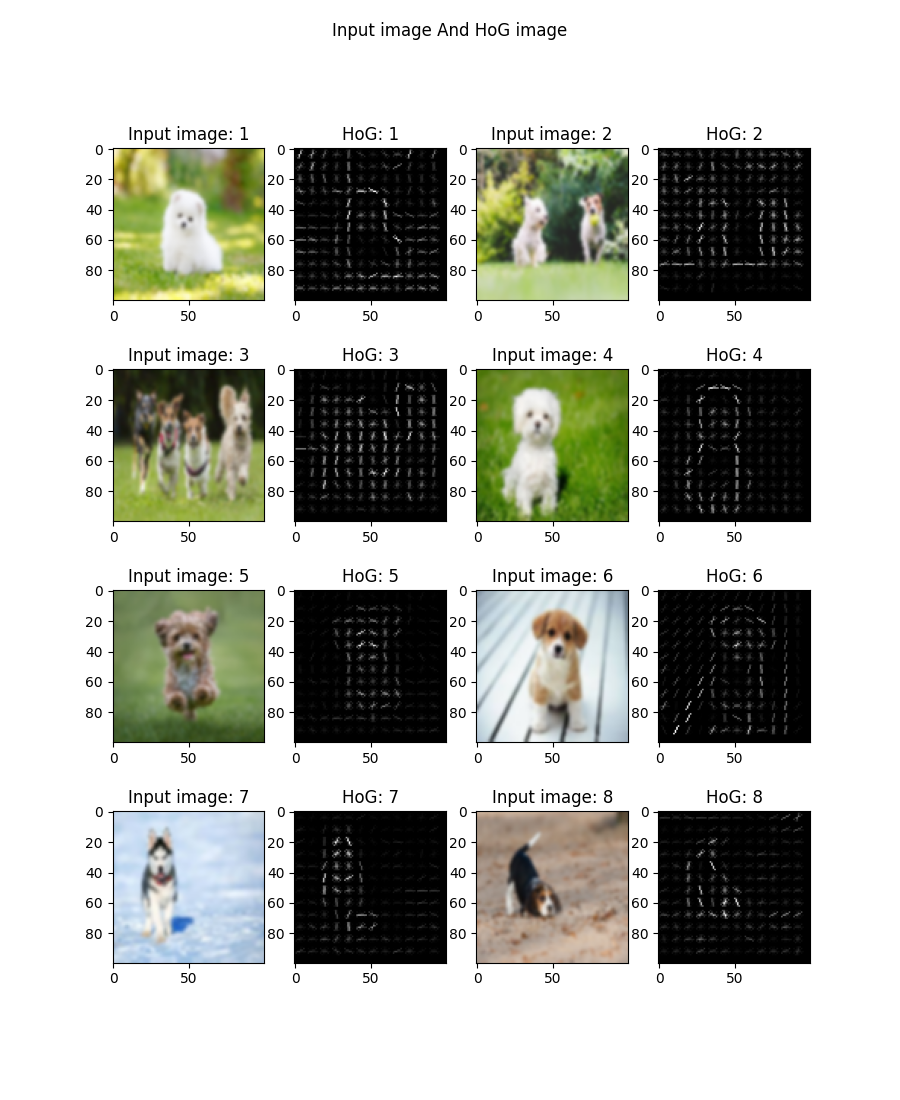

In [3]:
# #Display Image
fig = plt.figure(figsize=(9, 11))
fig.suptitle("Input image And HoG image")
rows = 4
columns = 4

for indexImage, indexPlot in enumerate(range(1, 16,2)):
    fig.add_subplot(rows, columns, indexPlot)
    plt.title('Input image: '+str(indexImage+1))
    plt.imshow(main_images[indexImage])
    plt.show()
    
for indexImage, indexPlot in enumerate(range(2, 17,2)):
    fig.add_subplot(rows, columns, indexPlot)
    plt.title('HoG: '+str(indexImage+1))
    plt.imshow(hog_images[indexImage], cmap='gray')
    plt.show()

<IPython.core.display.Javascript object>


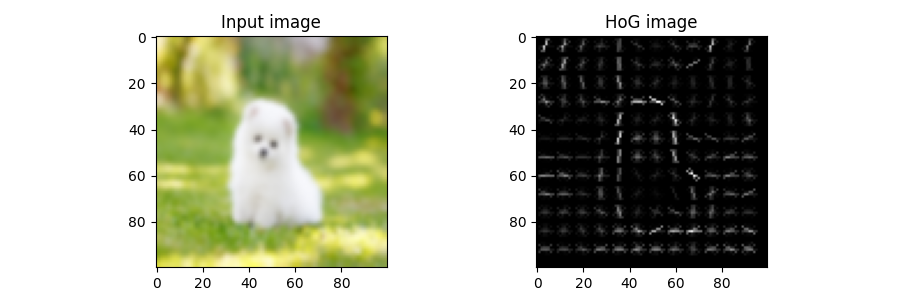

In [4]:
#Display Image
fig = plt.figure(figsize=(9, 3))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.title('Input image')
plt.imshow(main_images[0], cmap='gray')
plt.show()
    
fig.add_subplot(rows, columns, 2)
plt.title('HoG image')
plt.imshow(hog_images[0], cmap='gray')
plt.show()

## 9.1.2 Prepare HoG feature of subimage

In [5]:
img = main_images[0]

#1. Define block size for subimage
block_size = (60,40)

#Define stride
stride = (1,1)


#2. Define sliding window position of row, column (Top left position)
posRow = np.arange(0, img.shape[1]-block_size[0], stride[0])
posCol = np.arange(0, img.shape[0]-block_size[1], stride[1])


#3. Create subimage featureS
#Calculate HoG of each subimage in Sliding window\
hog_features = []
sliding_images = []
sliding_hog_images = []

for i in posRow:
    for j in posCol:
        startH = posRow[i]
        endH = posRow[i] + block_size[0]
        startW = posCol[j]
        endW = posCol[j] + block_size[1]
        
        subImg = img[startH:endH, startW:endW, :]
        sliding_images.append(subImg)
        
        blur = cv2.GaussianBlur(subImg, (5,5), 0)
        fd, hog_image = hog(blur, orientations=9, pixels_per_cell=(4, 4), 
                        cells_per_block=(2,2), visualize=True, multichannel=True)
        
        hog_features.append(fd)
        sliding_hog_images.append(hog_image)

<IPython.core.display.Javascript object>


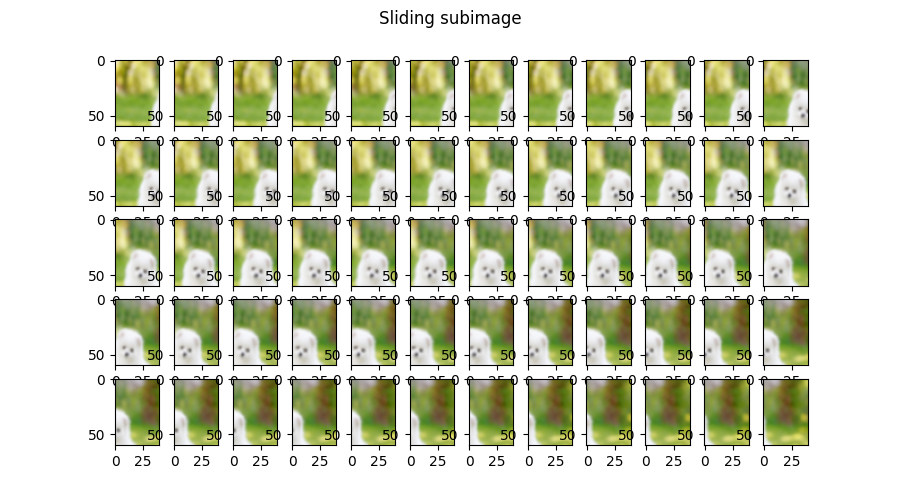

In [6]:
#Display sliding window
fig = plt.figure(figsize=(9, 5))
fig.suptitle('Sliding subimage')
rows = 5
columns = 12 

for i in range(60):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(sliding_images[i])
    plt.show()

<IPython.core.display.Javascript object>


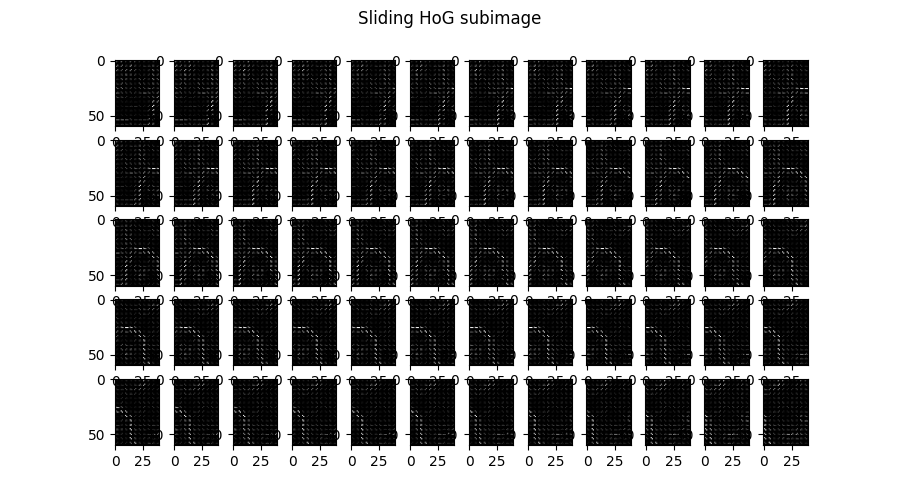

In [7]:
#Display sliding window
fig = plt.figure(figsize=(9, 5))
fig.suptitle('Sliding HoG subimage')
rows = 5
columns = 12

for i in range(60):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(sliding_hog_images[i], cmap='gray')
    plt.show()

---

# 9.2 Image Segmentation using K-mean clustering
- Foreground (FG)
- Background (BG)

## 9.2.1 K-Mean clustering

In [8]:
#1. Clean feature if NA
# fillna(0)
np.nan_to_num(hog_features)

#2. K-Mean clustering
N = 2
kmeans = KMeans(n_clusters=N, random_state=0)
clusters = kmeans.fit_predict(hog_features)

## 9.2.2 Region Of Interest (ROI)

(40, 60)
[[0 0 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


<IPython.core.display.Javascript object>


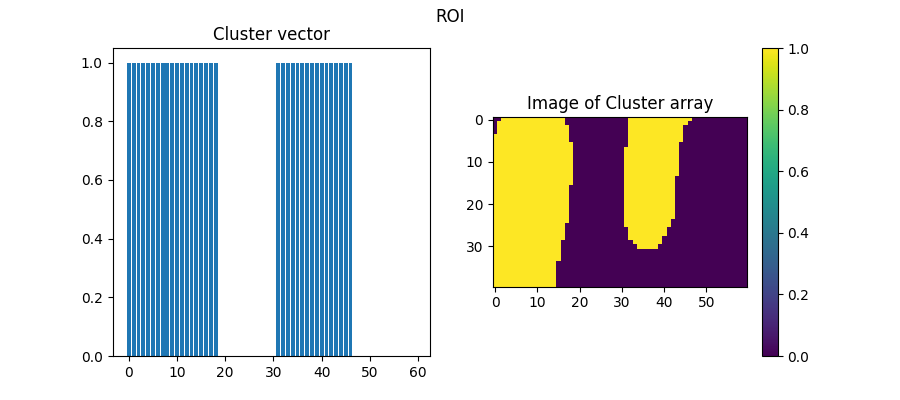

In [9]:
cluster_array = clusters.reshape(len(posRow), len(posCol))

print(cluster_array.shape)
print(cluster_array)

#Display 
fig = plt.figure(figsize=(9, 4))
fig.suptitle('ROI')
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
for i in range(len(cluster_array)):
    plt.bar(range(len(cluster_array[i])), cluster_array[i], color='#1f77b4')

plt.title('Cluster vector')

fig.add_subplot(rows, columns, 2)
plt.imshow(cluster_array)
plt.colorbar()
plt.title('Image of Cluster array')

plt.show()

---

# 9.3 ROI: Region Of Interest Drawing ROI bounding box

## 9.3.1 K-Mean clustering

In [10]:
#1. ReAssign Label in case of multiple ROIs with the same clusterID
all_labels = label(cluster_array)

#Define Bounding box parameter
color = (255, 0, 0)
thickness = 1

<IPython.core.display.Javascript object>


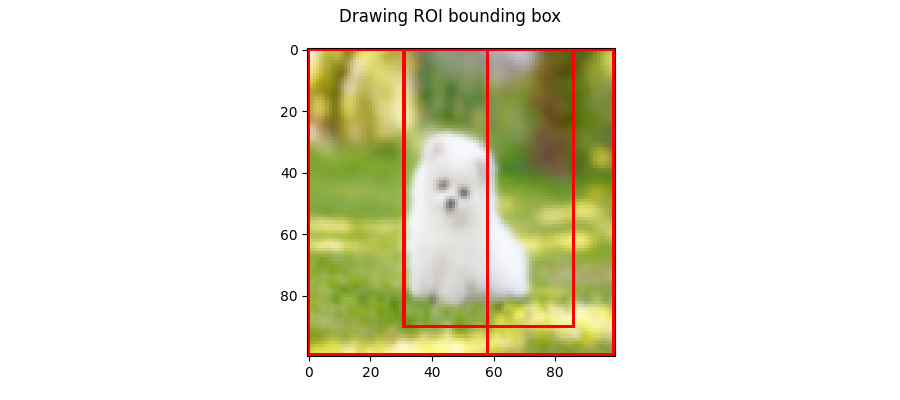

In [11]:
    
#Display 
fig = plt.figure(figsize=(9, 4))
fig.suptitle('Drawing ROI bounding box')
rows = 1
columns = 1

#2. ROI bounding box
nClass = np.unique(all_labels)

ROI_bounding_img = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

for i in nClass:
    #calculate from grid to actual position
    objPos = np.argwhere(all_labels == i)
    
    startBlockH = objPos[:,0].min()
    endBlockH = objPos[:,0].max()
    
    startBlockW = objPos[:,1].min()
    endBlockW = objPos[:,1].max()
    
    startF = (posCol[startBlockW], posRow[startBlockH])
    endF = (posCol[endBlockW]+block_size[1], posRow[endBlockH]+block_size[0])
    
    ROI_bounding_img = cv2.rectangle(img, startF, endF, color, thickness)

fig.add_subplot(rows, columns, 1)
plt.imshow(ROI_bounding_img)
plt.show()